In [730]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [731]:
DATASET_NAME = 'zbiór_15.csv'
TARGET_COLUMN = 'default'
RANDOM_STATE = 4
IV_DROP_THRESHOLD = 0.3
CORRELATION_DROP_THRESHOLD = 0.8
TEST_SIZE = 0.2
RANDOM_FORREST_N_ESTIMATORS = 300

In [732]:
data = pd.read_csv(DATASET_NAME)
data.head()

,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,214,6201,8993,112709.98,0.00,0.0,0.0,0.00,0.00,...,0.950530,0.950530,0.052044,0.000000,0.000000,0.000000,0.049470,0.049470,0.950530,1
1,117,214,4110,2607,2369051.57,5063.80,0.0,0.0,5063.80,5063.80,...,0.264511,0.271964,2.780566,0.000000,0.444723,0.444723,0.735489,0.708082,0.262935,1
2,117,215,7022,5868,71925.97,0.00,0.0,0.0,0.00,0.00,...,0.944960,0.944960,0.058246,0.055040,0.000000,0.000000,0.055040,0.055040,0.944960,1
3,117,214,6920,1668,12247.82,0.00,0.0,0.0,0.00,0.00,...,0.774826,0.774826,0.290612,0.225174,0.000000,0.000000,0.225174,0.225174,0.774826,1
4,117,214,6619,1994,614984.31,131077.01,0.0,0.0,118777.01,118777.01,...,0.394975,1.251990,1.531805,0.206732,0.371039,0.371039,0.605025,-0.079497,0.231091,1


In [733]:
data.describe()

e:\conda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,3000.0,3000.000000,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,...,3000.000000,2957.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,117.0,200.979667,5344.899000,4043.084000,7.736907e+06,5.146257e+06,4.285282e+04,4.747901e+03,1.131901e+06,1.011080e+06,...,5.092878,NaN,14.869922,1.892967,1.938928,1.940652,14.663446,9.615697,-6.743099,0.053000
std,0.0,51.816209,1962.118082,2794.093839,9.986779e+07,8.898365e+07,9.220774e+05,9.643449e+04,5.362261e+06,5.018179e+06,...,119.399309,NaN,392.698022,58.012314,59.058917,59.058880,497.022096,373.166334,681.316755,0.224071
min,117.0,0.000000,0.000000,1204.000000,0.000000e+00,0.000000e+00,-5.800000e-01,0.000000e+00,0.000000e+00,-8.739250e+03,...,-939.811838,-inf,-1.351786,-16.265592,-17.825569,-17.825569,-180.575028,-1844.269400,-32062.387100,0.000000
25%,117.0,214.000000,4321.000000,1805.750000,8.797910e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.348431,0.412853,0.074446,0.000000,0.000000,0.000000,0.069078,-0.066635,0.081244,0.000000
50%,117.0,214.000000,4941.000000,3009.000000,5.992333e+05,2.230695e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.658558,0.794606,0.447030,0.000000,0.000000,0.000000,0.309920,0.135711,0.508948,0.000000
75%,117.0,215.000000,6920.000000,5636.750000,2.709980e+06,5.616736e+05,0.000000e+00,0.000000e+00,1.350023e+05,1.024320e+05,...,0.904009,1.063178,1.537708,0.190159,0.102220,0.103234,0.612969,0.490105,0.857255,0.000000
max,117.0,338.000000,9609.000000,16617.000000,4.532282e+09,4.531929e+09,4.860000e+07,3.933141e+06,1.202187e+08,1.191571e+08,...,4300.000000,inf,20866.570800,2638.471300,2557.170400,2557.170400,24378.434200,16593.611300,15211.326300,1.000000


In [734]:
list(data.columns)

['szczegolnaFormaPrawna_Symbol',
 'formaWlasnosci_Symbol',
 'pkdKod',
 'wsk_liczba_dni_istnienia',
 'Aktywa',
 'Aktywa_trwale',
 'Wartosci_niematerialne_prawne',
 'Wartosc_firmy',
 'Rzeczowe_aktywa_trwale',
 'Srodki_trwale',
 'Naleznosci_dlugoterminowe',
 'Inwestycje_dlugoterminowe',
 'Rozliczenia_miedzyokresowe_dlugie',
 'Aktywa_obrotowe',
 'Zapasy',
 'Naleznosci_krotkoterminowe',
 'Naleznosci_dostaw_uslug_12m_powiazane',
 'Naleznosci_dostaw_uslug_pow12m_powiazane',
 'Naleznosci_dostaw_uslug_12m_kapitale',
 'Naleznosci_dostaw_uslug_pow12m_kapitale',
 'Naleznosci_dostaw_uslug_12m_pozostale',
 'Naleznosci_dostaw_uslug_pow12m_pozostale',
 'Naleznosci_dostaw_uslug_pozostale_sadowe',
 'Inwestycje_krotkoterminowe',
 'Srodki_pieniezne',
 'Rozliczenia_miedzyokresowe_krotkie',
 'Kapital_wlasny',
 'Kapital_podstawowy',
 'Kapital_zapasowy',
 'Zysk_netto',
 'Zobowiazania_rezerwy',
 'Rezerwy_na_zobowiazania',
 'Rezerwa_z_tytulu_odroczonego_podatku_dochodowego',
 'Rezerwa_na_swiadczenia_emerytalne'

In [735]:
print("Default count: " + str(data[TARGET_COLUMN].value_counts()[1]))
print("No default count: " + str(data[TARGET_COLUMN].value_counts()[0]))

Default count: 159
No default count: 2841


## Undersample data TODO: zamienić na kalibrację

In [736]:
default_class = data[data[TARGET_COLUMN] == 1]
no_default_class = data[data[TARGET_COLUMN] == 0]

no_default_undersampled = no_default_class.sample(n=len(default_class), random_state=RANDOM_STATE)

balanced_data = pd.concat([default_class, no_default_undersampled])

data = balanced_data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [737]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['schemat_wsk_bilans', 'schemat_wsk_rzis'], dtype='object')


In [738]:
data[categorical_features].head(10)

,schemat_wsk_bilans,schemat_wsk_rzis
0,SFJIN,SFJIN
1,SFJMA,SFJMA
2,SFJIN,SFJIN
3,SFJIN,SFJIN
4,SFJMI,SFJMI
5,SFJIN,SFJIN
6,SFJIN,SFJIN
7,SFJMI,SFJMI
8,SFJIN,SFJIN
9,SFJIN,SFJIN


## One hot encode categorical features

In [739]:
one_hot_encoded = pd.get_dummies(data[categorical_features])
data = pd.concat([data, one_hot_encoded], axis=1)
data = data.drop(categorical_features, axis=1)

## Replace NaNs with median

In [740]:
data = data.fillna(data.median())
data.describe()

e:\conda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
count,318.0,318.000000,318.000000,318.000000,3.180000e+02,3.180000e+02,3.180000e+02,318.000000,3.180000e+02,3.180000e+02,...,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,117.0,200.034591,5378.694969,3745.308176,1.372281e+07,4.429514e+06,3.075942e+04,1949.707044,6.613224e+05,6.103488e+05,...,7.622896,inf,85.292555,0.160274,0.097459,0.097693,6.848080,-1.213414,-1.017027,0.500000
std,0.0,55.016562,1879.380423,2731.582142,1.438272e+08,4.665776e+07,2.465286e+05,32161.427283,3.900595e+06,3.797718e+06,...,122.974660,NaN,1180.709981,0.293650,0.216373,0.216521,114.945012,24.498144,15.126763,0.500788
min,117.0,0.000000,111.000000,1265.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,-0.663579,-6.719194,0.000000,-0.650920,0.000000,-0.003249,-0.003249,-436.599500,-231.748590,0.000000
25%,117.0,214.000000,4314.250000,1722.250000,2.431869e+04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.189227,0.233734,0.038877,0.000000,0.000000,0.000000,0.037422,-0.051410,0.013719,0.000000
50%,117.0,214.000000,4941.000000,2607.000000,2.552749e+05,2.765415e+03,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.579012,0.760213,0.530355,0.000000,0.000000,0.000000,0.354932,0.132205,0.473512,0.500000
75%,117.0,215.000000,6920.000000,5107.750000,1.477452e+06,2.472718e+05,0.000000e+00,0.000000,3.479025e+04,1.242620e+04,...,0.924062,1.017850,2.885059,0.181893,0.059171,0.059171,0.761198,0.570944,0.879210,1.000000
max,117.0,338.000000,9609.000000,15903.000000,2.271510e+09,7.780259e+08,2.926000e+06,571629.000000,5.841600e+07,5.841600e+07,...,2193.260500,inf,20866.570800,0.999376,0.972376,0.972376,2050.155600,0.999503,50.000000,1.000000


# Replace inf and -inf with max and min value from column

In [741]:
missing_columns = ['wsk_plynnosc_biez_1', 'wsk_struktura_kap_wlasnego_s_2', 'wsk_kapital_do_aktywa']

# Replace 'inf' with maximum value and '-inf' with minimum value in each column
for column in missing_columns:
    max_value = data[column].replace([np.inf, -np.inf], np.nan).max()
    min_value = data[column].replace([np.inf, -np.inf], np.nan).min()
    data[column].replace([np.inf, -np.inf], np.nan, inplace=True)
    data[column].fillna(max_value, inplace=True)  # Replace 'inf' with max
    data[column].replace(-np.inf, min_value, inplace=True)  # Replace '-inf' with min

## Remove outliers TODO: przepisywać skopiowane!!

In [742]:
def replace_outliers(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    data_without_outliers = np.clip(column, lower_bound, upper_bound)
    
    return data_without_outliers

numeric_features_no_target = [col for col in numeric_features if col != TARGET_COLUMN]

outliers_num = 0
for column in data[numeric_features_no_target].columns:
    data[column] = replace_outliers(data[column])
    outliers_num += 1

## TODO: Annova

In [743]:
def calculate_woe_iv(data, variable, target):
    # Create bins for numerical variables
    if pd.api.types.is_numeric_dtype(data[variable]):
        bins_variable = variable + '_bins'
        data[bins_variable] = pd.qcut(data[variable], q=20, duplicates='drop')

        # Create a table with counts of each category and the count of target = 1
        grouped = data.groupby(bins_variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})
    else:
        # Create a table with counts of each category and the count of target = 1 for non-numeric variables
        grouped = data.groupby(variable)[target].agg(['count', 'sum'])
        grouped = grouped.rename(columns={'count': 'total', 'sum': 'events'})

    # Calculate WOE and IV
    grouped['non_events'] = grouped['total'] - grouped['events']

    # Add a small constant to prevent divide by zero
    eps = 1e-8
    grouped['event_rate'] = (grouped['events'] + eps) / (grouped['events'].sum() + eps)
    grouped['non_event_rate'] = (grouped['non_events'] + eps) / (grouped['non_events'].sum() + eps)

    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    # Sum up the IV values for each category
    iv = grouped['iv'].sum()

    return grouped, iv

In [744]:
# Calculate WOE and IV for each variable
data_copied = copy.deepcopy(data)

woe_iv_results = []
for column in data.columns:
    if column != TARGET_COLUMN:
        grouped_data, iv = calculate_woe_iv(data_copied, column, TARGET_COLUMN)
        woe_iv_results.append({'Variable': column, 'IV': iv})

# Sort the results by IV in descending order
woe_iv_results = sorted(woe_iv_results, key=lambda x: x['IV'])

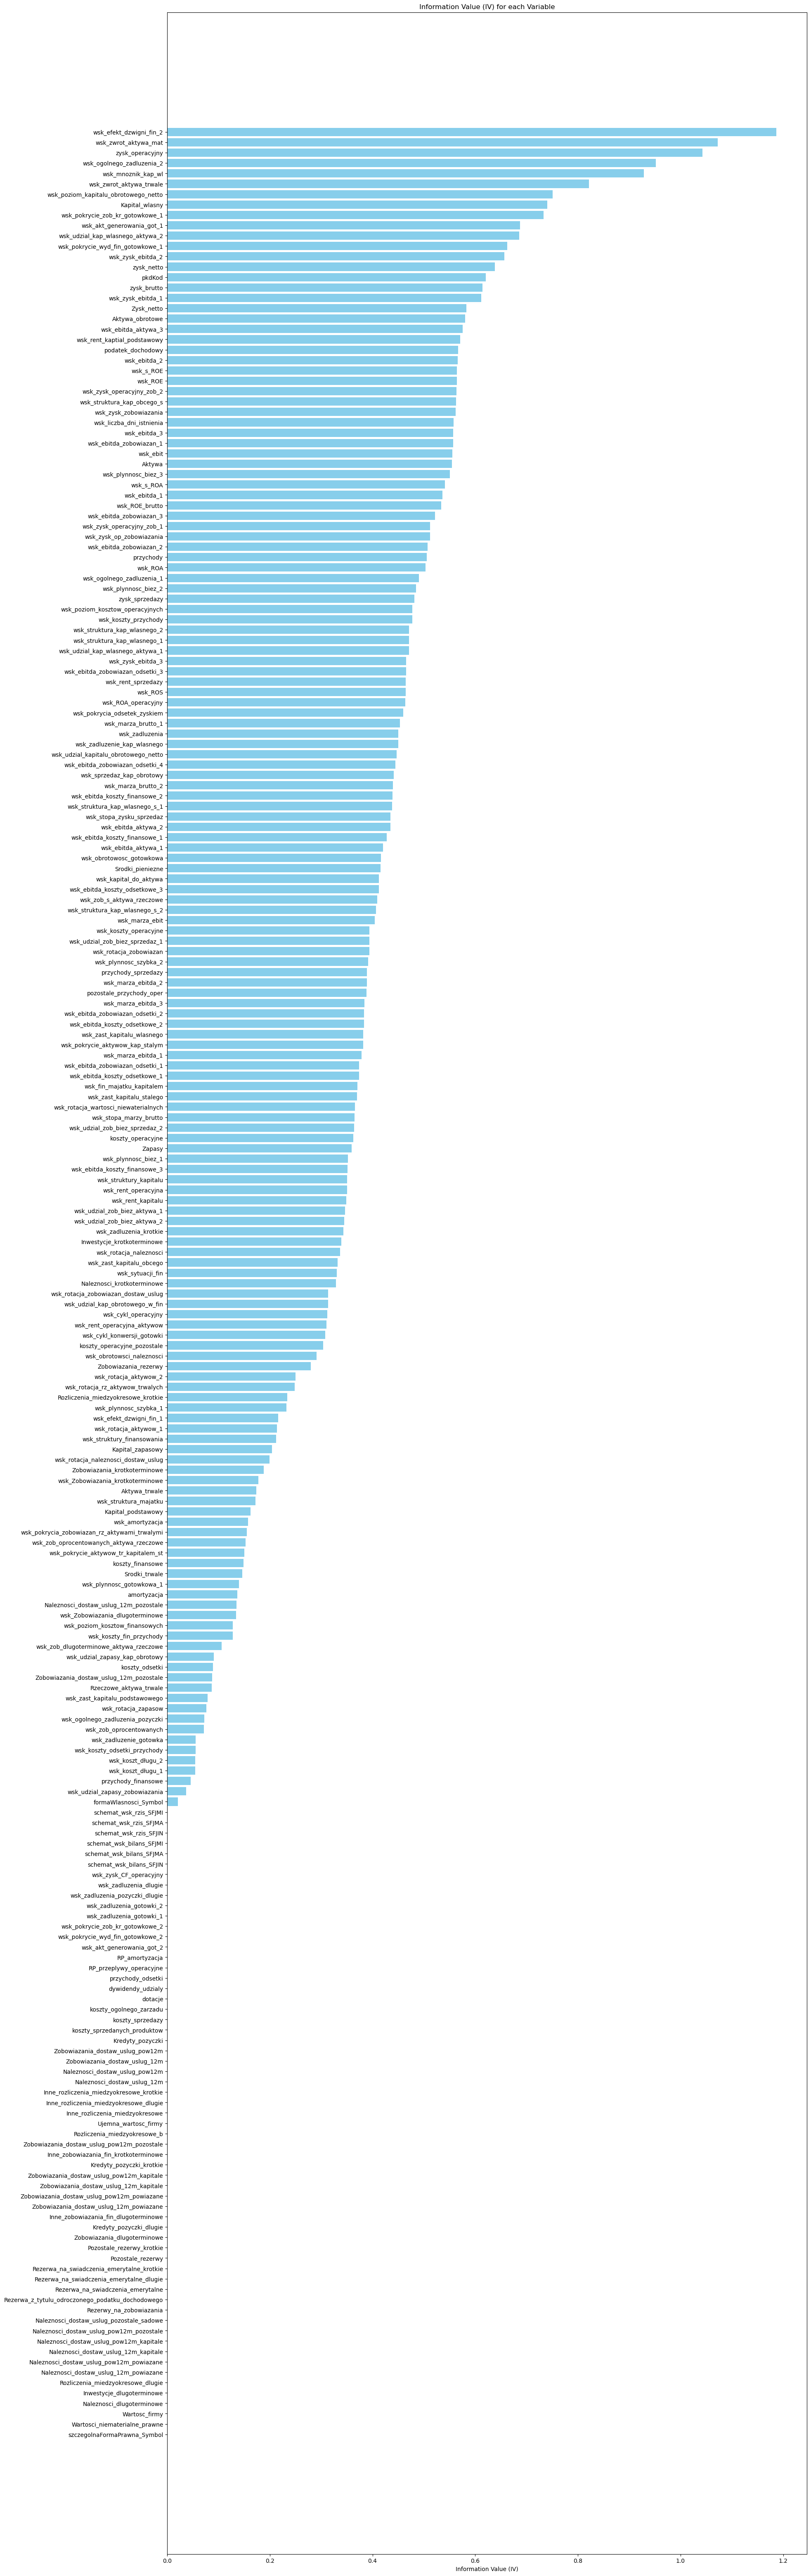

In [745]:
variables = [result['Variable'] for result in woe_iv_results]
iv_values = [result['IV'] for result in woe_iv_results]

# Create a bar plot
plt.figure(figsize=(20, 80))
plt.barh(variables, iv_values, color='skyblue')
plt.xlabel('Information Value (IV)')
plt.title('Information Value (IV) for each Variable')
plt.show()

## Drop low IV columns (albo od 0.1 albo od 0.3 możemy wywalać)

In [746]:
print("Number of colums before: " + str(len(data.columns)))
low_iv_columns = [result['Variable'] for result in woe_iv_results if result['IV'] < IV_DROP_THRESHOLD]
data.drop(low_iv_columns, axis=1, inplace=True)
print("Number of colums after: " + str(len(data.columns)))

Number of colums before: 224
Number of colums after: 119


## Drop highly correlated variables, take one with bigger IV

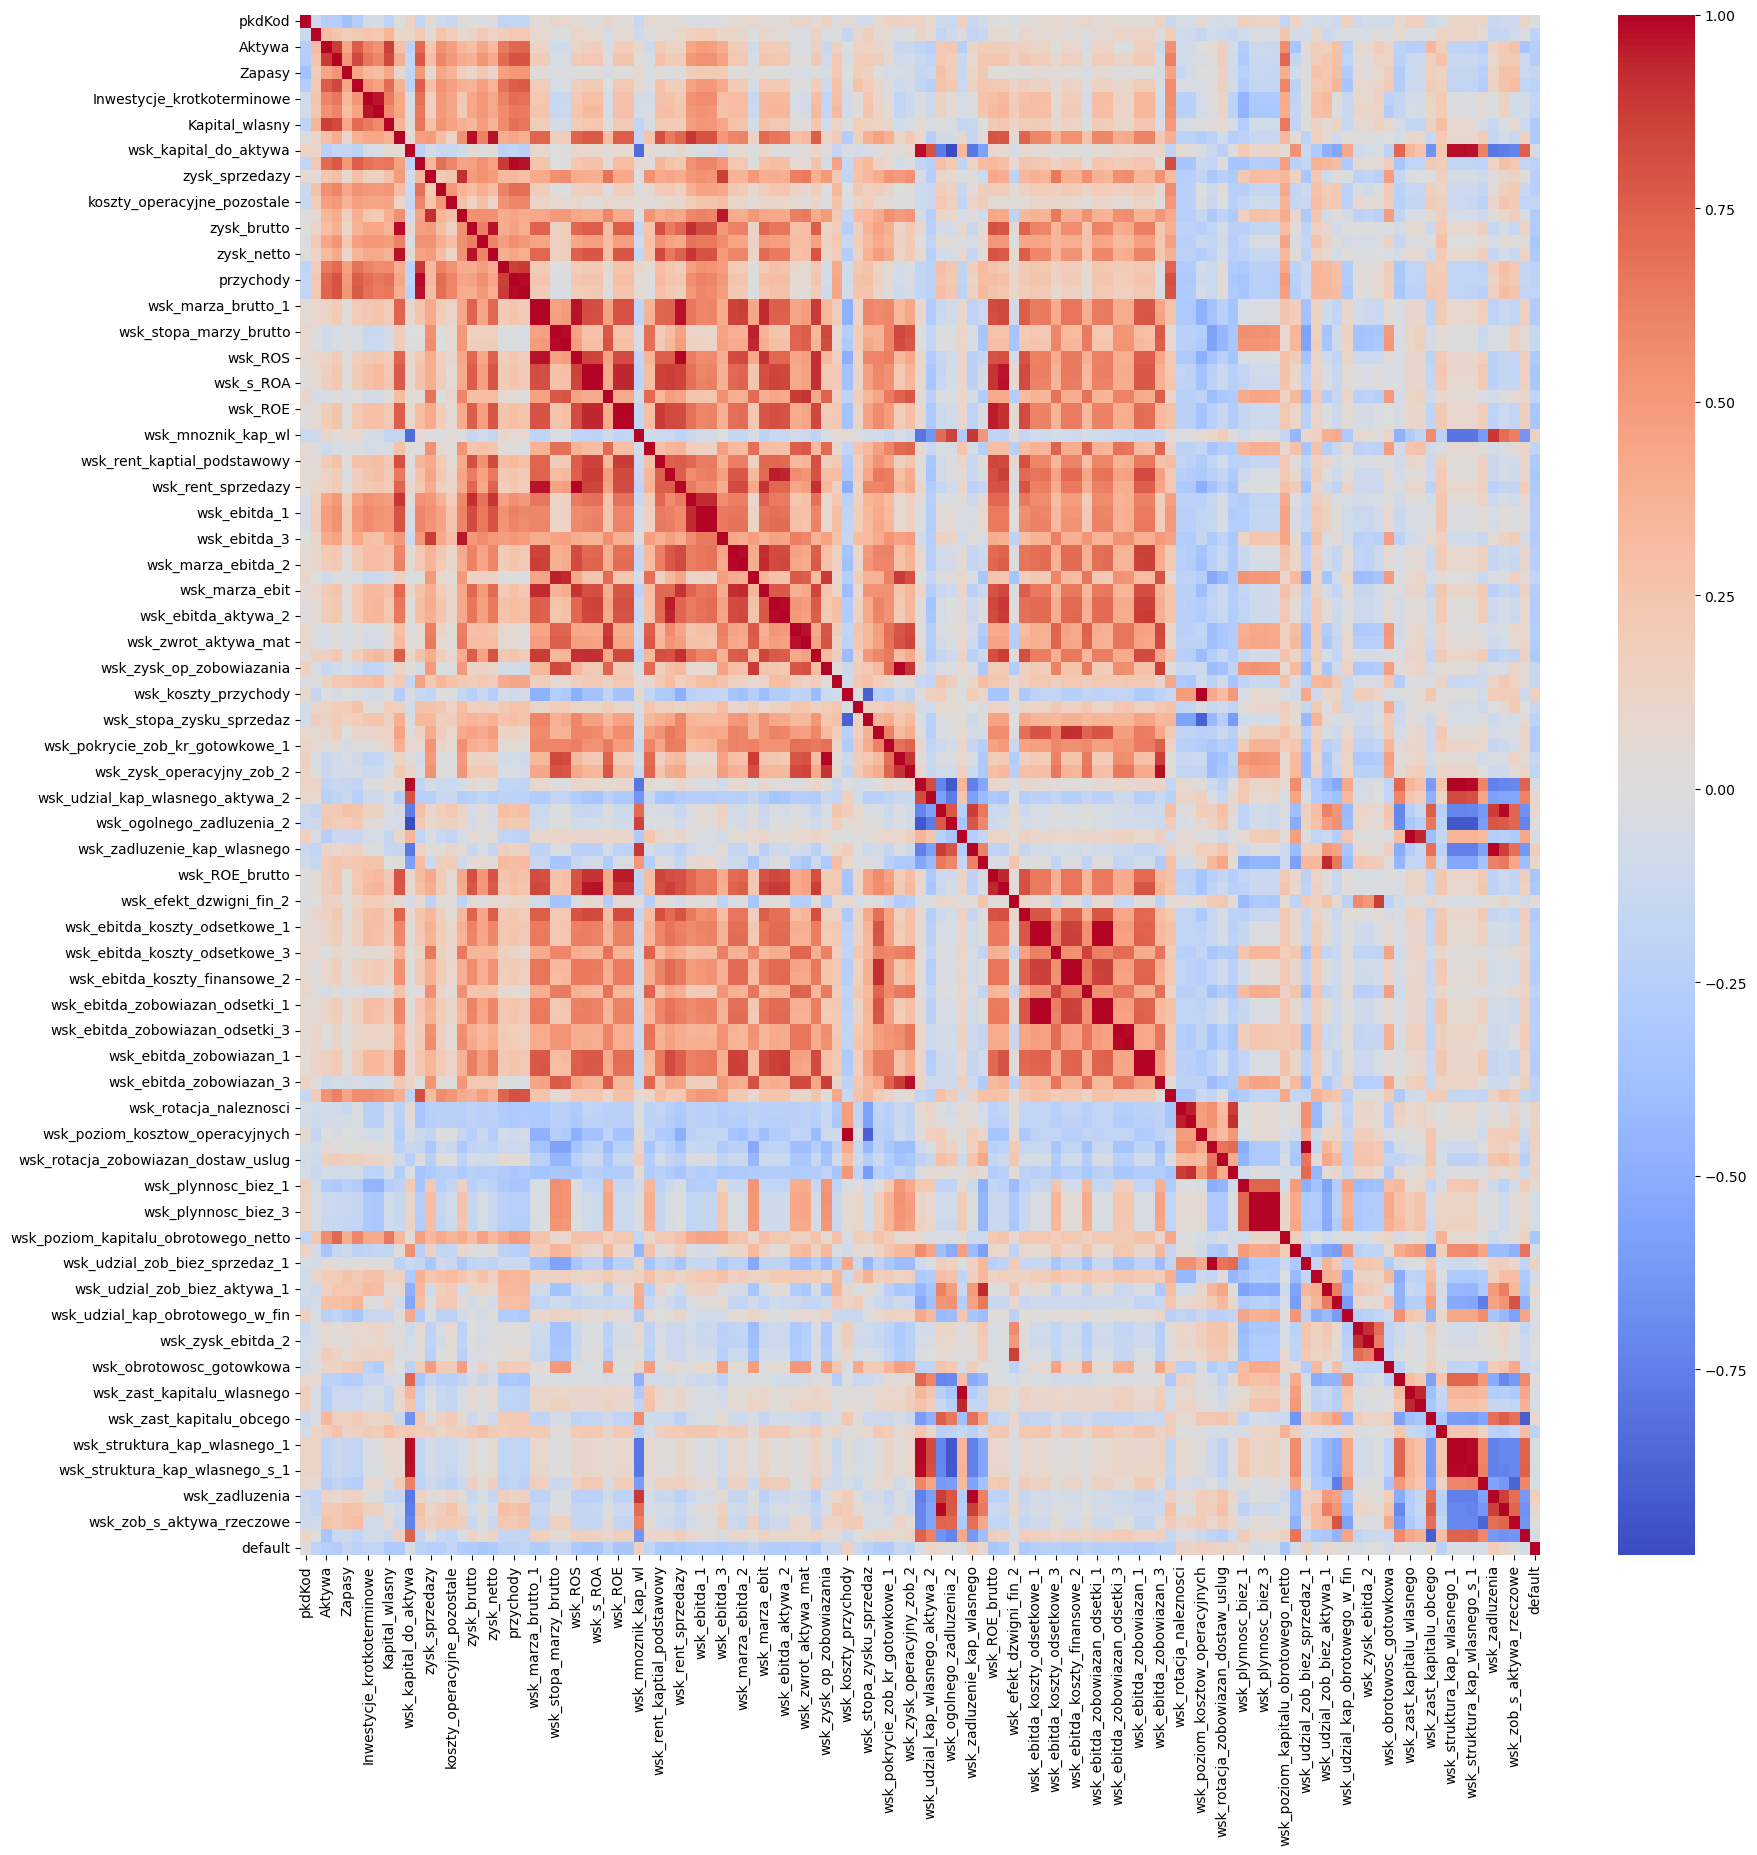

In [747]:
correlation_matrix = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

In [748]:
print("Number of colums before: " + str(len(data.columns)))

highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > CORRELATION_DROP_THRESHOLD:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(pair)

# Keep variables with higher IV in each pair
for pair in highly_correlated_pairs:
    var1, var2 = pair
    iv_var1 = next(item['IV'] for item in woe_iv_results if item['Variable'] == var1)
    iv_var2 = next(item['IV'] for item in woe_iv_results if item['Variable'] == var2)
    
    if var2 in data.columns and var1 in data.columns:
        if iv_var1 > iv_var2:
            # Keep var1, remove var2
            data = data.drop(var2, axis=1)
        else:
            # Keep var2, remove var1
            data = data.drop(var1, axis=1)

print("Number of colums after: " + str(len(data.columns)))

Number of colums before: 119
Number of colums after: 48


In [749]:
def calculate_auc_gini(y_test, y_pred_prob):
    auc = roc_auc_score(y_test, y_pred_prob)
    gini = 2 * auc - 1

    return auc, gini

In [750]:
def plot_feature_importances(model, features, title):
    feature_importances = model.feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [751]:
features = data.drop(TARGET_COLUMN, axis=1)
target = data[TARGET_COLUMN]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [752]:
model = RandomForestClassifier(n_estimators=RANDOM_FORREST_N_ESTIMATORS, random_state=RANDOM_STATE)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
auc, gini = calculate_auc_gini(y_test, model.predict_proba(X_test)[:, 1])
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {gini:.2f}')
print(report)

Accuracy: 0.72
AUC: 0.75
Gini: 0.51
              precision    recall  f1-score   support

           0       0.71      0.76      0.74        33
           1       0.72      0.68      0.70        31

    accuracy                           0.72        64
   macro avg       0.72      0.72      0.72        64
weighted avg       0.72      0.72      0.72        64



In [753]:
scores = cross_val_score(model, features, target, cv=5)
print(scores)

[0.640625   0.734375   0.625      0.65079365 0.6031746 ]


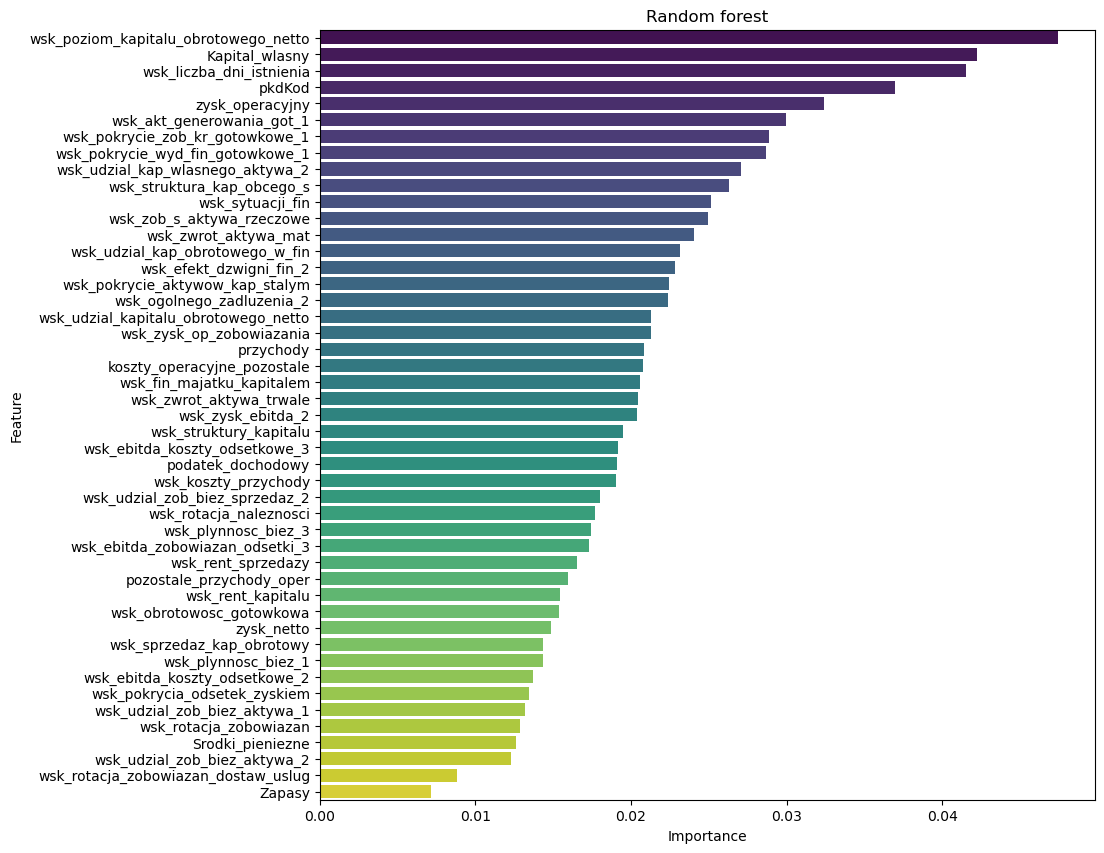

In [754]:
plot_feature_importances(model, features, "Random forest")

In [755]:
# Initialize XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
auc, gini = calculate_auc_gini(y_test, model.predict_proba(X_test)[:, 1])
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC: {auc:.2f}')
print(f'Gini: {gini:.2f}')
print(report)

Accuracy: 0.75
AUC: 0.76
Gini: 0.52
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        33
           1       0.73      0.77      0.75        31

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64



In [756]:
scores = cross_val_score(model, features, target, cv=5)
print(scores)

[0.671875   0.703125   0.5625     0.6031746  0.58730159]


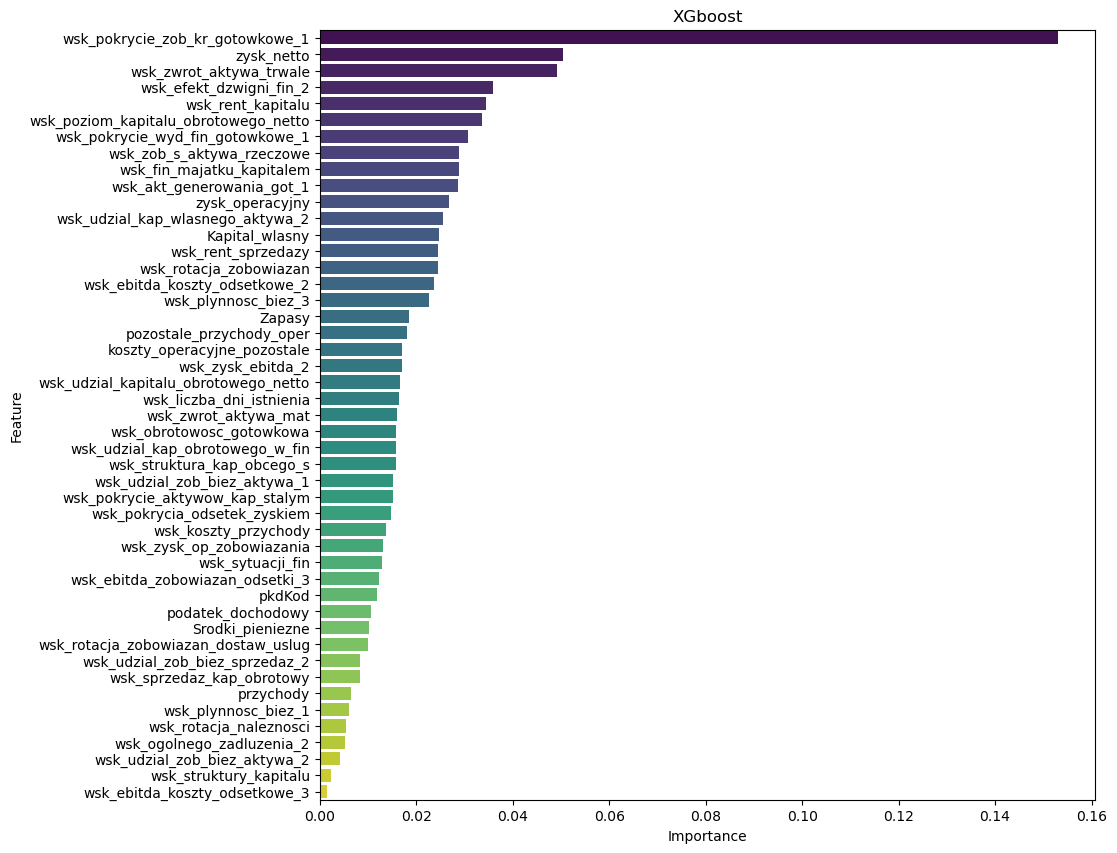

In [757]:
plot_feature_importances(model, features, "XGboost")